In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

In [43]:
import warnings
warnings.filterwarnings('ignore')


def load_and_merge_data(gen_path, weather_path):

    gen = pd.read_csv(gen_path)
    weather = pd.read_csv(weather_path)
    
    gen['DATE_TIME'] = pd.to_datetime(gen['DATE_TIME'], format='%d-%m-%Y %H:%M')
    weather['DATE_TIME'] = pd.to_datetime(weather['DATE_TIME'])
    
    merged = pd.merge(gen, weather, on='DATE_TIME', how='left')
    agg_rules = {
        'DC_POWER': 'sum',
        'AC_POWER': 'sum',
        'DAILY_YIELD': 'mean',
        'TOTAL_YIELD': 'mean',
        'AMBIENT_TEMPERATURE': 'mean',
        'MODULE_TEMPERATURE': 'mean',
        'IRRADIATION': 'sum'
    }
    aggregated = merged.groupby('DATE_TIME').agg(agg_rules)
    
    aggregated['hour'] = aggregated.index.hour
    aggregated['day_of_week'] = aggregated.index.dayofweek
    aggregated['month'] = aggregated.index.month
    
    return aggregated

SEQ_LENGTH = 24*4
TARGET_LENGTH = 4*24
N_FEATURES = 10

plant1 = load_and_merge_data('Plant_1_Generation_Data.csv', 'Plant_1_Weather_Sensor_Data.csv')

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(plant1)

def create_sequences(data, seq_length, target_length):
    X, y = [], []
    for i in range(len(data) - seq_length - target_length):

        seq = data[i:i+seq_length]
        target = data[i+seq_length:i+seq_length+target_length, 1]
        
        X.append(seq)
        y.append(target)
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, SEQ_LENGTH, TARGET_LENGTH)

train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:], y[train_size:]



model = Sequential([
    Bidirectional(LSTM(256, return_sequences=True), input_shape=(SEQ_LENGTH, N_FEATURES)),
    Dropout(0.2),
    LSTM(128),
    Dense(32, activation='relu'),
    Dense(TARGET_LENGTH)
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mae'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64
)

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 14s 281ms/step - loss: 1.7085 - mae: 0.2392 - val_loss: 1.2118 - val_mae: 0.2096
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 280ms/step - loss: 1.3468 - mae: 0.2374 - val_loss: 1.1491 - val_mae: 0.2097
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 277ms/step - loss: 1.2784 - mae: 0.2361 - val_loss: 1.1116 - val_mae: 0.2099
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 277ms/step - loss: 1.2428 - mae: 0.2371 - val_loss: 1.0846 - val_mae: 0.2101
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 275ms/step - loss: 1.2135 - mae: 0.2371 - val_loss: 1.0639 - val_mae: 0.2104
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 275ms/step - loss: 1.1859 - mae: 0.2365 - val_loss: 1.0474 - val_mae: 0.2107
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 274ms/step - loss: 1.1661 - mae: 0.2370 - val_loss: 1.0337 - val_mae: 0.2111
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 275ms/step - loss: 1.1513 - mae: 0.2366 - val_loss: 1.0223 - val_mae: 0.2114
Epoch 9/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 274ms/

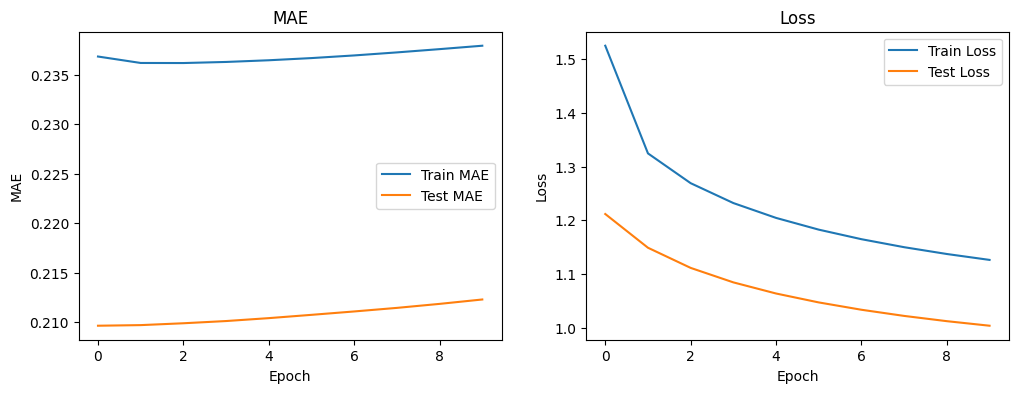

In [46]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history["mae"], label="Train MAE")
plt.plot(history.history["val_mae"], label="Test MAE")
plt.title("MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Test Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [49]:
def predict_future(model, last_sequence, future_steps, scaler, feature_index=1):
    predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(future_steps):

        next_step_scaled = model.predict(current_sequence[np.newaxis, ...])[0]
        fake_row = np.zeros((1, N_FEATURES))
        fake_row[0, feature_index] = next_step_scaled[0]
        next_step = scaler.inverse_transform(fake_row)[0, feature_index]
        predictions.append(next_step)

        current_sequence = np.roll(current_sequence, -1, axis=0)
        
        fake_row_full = np.zeros((1, N_FEATURES))
        fake_row_full[0, feature_index] = next_step_scaled[0]
        current_sequence[-1] = scaler.transform(fake_row_full)[0]
    
    return np.array(predictions)

seq = X_val[-1]
future_predictions = predict_future(model, seq, 10, scaler)
future_predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


array([2130.15145832, 2130.15145832, 2130.15145832, 2130.15145832,
       2130.15145832, 2130.15145832, 2130.15145832, 2130.15145832,
       2130.15145832, 2130.15145832])

Я предиктил вырабатываемое количество электроэнергии переменного тока 

и вероятно качество модели далеко не лучшее по причине длинных последовательностей нулей в соответствующем столбце